In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from pathlib import Path
import pandas as pd

# Visualization
import seaborn as sns
import pyLDAvis

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import joblib

# gensim for alternative models
# gensim: NLP library with a fast LDA implementation and many additional features
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.matutils import Sparse2Corpus

C:\Users\19498\AppData\Local\Programs\Python\Python3_8\lib\site-packages\gensim\matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


In [2]:
sns.set_style('white')
pyLDAvis.enable_notebook()

# change to your data path if necessary
DATA_DIR = Path('data')

path = DATA_DIR / 'bbc'
files = path.glob('**/*.txt')
doc_list = []
for i, file in enumerate(files):
    with open(str(file), encoding='latin1') as f:
        topic = file.parts[-2]
        lines = f.readlines()
        heading = lines[0].strip()
        body = ' '.join([l.strip() for l in lines[1:]])
        doc_list.append([topic.capitalize(), heading, body])

In [3]:
# Convert to DataFrame
docs = pd.DataFrame(doc_list, columns=['topic', 'heading', 'article'])
docs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   topic    2225 non-null   object
 1   heading  2225 non-null   object
 2   article  2225 non-null   object
dtypes: object(3)
memory usage: 52.3+ KB


In [4]:
# Create Train & Test Sets
train_docs, test_docs = train_test_split(docs, stratify=docs.topic, test_size=50, random_state=42)

In [5]:
train_docs.shape, test_docs.shape

((2175, 3), (50, 3))

In [6]:
pd.Series(test_docs.topic).value_counts()

Sport            12
Business         11
Entertainment     9
Tech              9
Politics          9
Name: topic, dtype: int64

In [7]:
vectorizer = CountVectorizer(max_df=.2, min_df=3, stop_words='english', max_features=2000)

train_dtm = vectorizer.fit_transform(train_docs.article)
words = vectorizer.get_feature_names()
train_dtm

<2175x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 178762 stored elements in Compressed Sparse Row format>

In [8]:
test_dtm = vectorizer.transform(test_docs.article)
test_dtm

<50x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 4048 stored elements in Compressed Sparse Row format>

In [9]:
# LDA with gensim
max_df = .2 # ignore words that appear on the documents over 50% = limit frequent appearing words
min_df = 3 # ignore words that appear on the documents below 3 counts = limit sparse words
max_features = 2000

stop_words = pd.read_csv('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words', header=None,
                         squeeze=True).tolist()

In [10]:
vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, stop_words='english', max_features=max_features)

train_dtm = vectorizer.fit_transform(train_docs.article)
test_dtm = vectorizer.transform(test_docs.article)

In [11]:
# Convert sklearn DTM to gensim data structures
train_corpus = Sparse2Corpus(train_dtm, documents_columns=False)
test_corpus = Sparse2Corpus(test_dtm, documents_columns=False)
id2word = pd.Series(vectorizer.get_feature_names()).to_dict()

In [13]:
num_topics = 5
topic_labels = ['Topic {}'.format(i) for i in range(1, num_topics+1)]

lda_gensim = LdaModel(corpus=train_corpus, num_topics=num_topics, id2word=id2word)

topics = lda_gensim.print_topics()
topics[0]

(0,
 '0.008*"company" + 0.005*"lord" + 0.005*"firm" + 0.005*"film" + 0.004*"chief" + 0.004*"used" + 0.004*"yukos" + 0.004*"statement" + 0.003*"legal" + 0.003*"case"')

  Topic 1         Topic 2          Topic 3          Topic 4           Topic 5        
     prob    term    prob     term    prob     term    prob      term    prob    term
0   0.77%    best   0.59%    blair   0.77%  company   0.81%     party   0.58%     win
1   0.67%    game   0.52%  economy   0.52%     lord   0.78%    labour   0.54%    game
2   0.63%   music   0.42%      say   0.51%     firm   0.64%  election   0.46%  second
3   0.51%   games   0.41%    brown   0.48%     film   0.49%     plans   0.44%    play
4   0.44%  mobile   0.40%   labour   0.41%    chief   0.47%   kennedy   0.43%   match


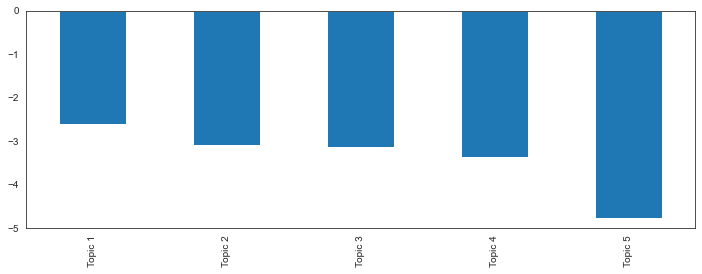

In [31]:
# Evaluate Topic Coherence
coherence = lda_gensim.top_topics(corpus=train_corpus, coherence='u_mass')

topic_coherence = []
topic_words = pd.DataFrame()
for t in range(len(coherence)):
    label = topic_labels[t]
    topic_coherence.append(coherence[t][1])
    df = pd.DataFrame(coherence[t][0], columns=[(label, 'prob'), (label, 'term')])
    df[(label, 'prob')] = df[(label, 'prob')].apply(lambda x: '{:.2%}'.format(x))
    topic_words = pd.concat([topic_words, df], axis=1)

topic_words.columns = pd.MultiIndex.from_tuples(topic_words.columns)
pd.set_option('expand_frame_repr', False) # expansion of the column line limit
topic_words.head().to_csv('topic_words.csv', index=False)
print(topic_words.head())

pd.Series(topic_coherence, index=topic_labels).plot.bar(figsize=(12,4));

In [15]:
# Using gensim Dictionary
docs = [d.split() for d in train_docs.article.tolist()]
docs = [[t for t in doc if t not in stop_words] for doc in docs]

dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=min_df, no_above=max_df, keep_n=max_features)

corpus = [dictionary.doc2bow(doc) for doc in docs]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 2000
Number of documents: 2175


In [16]:
num_topics = 5
chunksize = 500
passes = 20
iterations = 400
eval_every = None # Don't evaluate model perplexity, takes too much time.

temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, alpha='auto', eta='auto',
                 iterations=iterations, num_topics=num_topics, passes=passes, eval_every=eval_every)

model.show_topics()

[(0,
  '0.008*"company" + 0.007*"market" + 0.006*"economic" + 0.006*"chief" + 0.006*"growth" + 0.006*"firm" + 0.006*"sales" + 0.006*"economy" + 0.005*"rise" + 0.005*"oil"'),
 (1,
  '0.010*"game" + 0.009*"win" + 0.008*"England" + 0.007*"play" + 0.007*"good" + 0.006*"team" + 0.006*"think" + 0.006*"club" + 0.006*"got" + 0.006*"really"'),
 (2,
  '0.022*"best" + 0.016*"film" + 0.010*"won" + 0.008*"music" + 0.007*"British" + 0.007*"including" + 0.007*"director" + 0.007*"New" + 0.006*"UK" + 0.006*"Wales"'),
 (3,
  '0.012*"government" + 0.010*"Labour" + 0.009*"Blair" + 0.007*"public" + 0.007*"election" + 0.006*"Brown" + 0.006*"say" + 0.006*"Lord" + 0.006*"party" + 0.005*"plans"'),
 (4,
  '0.009*"mobile" + 0.009*"technology" + 0.009*"use" + 0.008*"music" + 0.007*"digital" + 0.007*"users" + 0.007*"games" + 0.006*"used" + 0.006*"net" + 0.006*"software"')]

In [17]:
# Evaluating Topic Assignments on the Test Set
docs_test = [d.split() for d in test_docs.article.tolist()]
docs_test = [[t for t in doc if t not in stop_words] for doc in docs_test]

test_dictionary = Dictionary(docs_test)
test_dictionary.filter_extremes(no_below=min_df, no_above=max_df, keep_n=max_features)
test_corpus = [dictionary.doc2bow(doc) for doc in docs_test]

gamma, _ = model.inference(test_corpus)
topic_scores = pd.DataFrame(gamma)
topic_scores.head(10)

,0,1,2,3,4
0,9.224776,0.100198,30.881353,0.101417,2.172622
1,0.114528,17.738140,0.097544,9.548802,87.956863
2,10.057119,5.600917,5.780658,0.101433,108.916023
3,68.764313,0.100207,0.097538,13.431551,0.076570
4,3.950819,32.365269,1.987029,0.101432,0.076571
5,53.313030,47.525173,0.097546,0.101442,19.418892
6,104.299553,1.826268,0.097534,10.156130,0.076571
7,2.427577,88.347198,15.502679,0.101435,0.076570
8,67.000450,2.798453,0.097540,0.101420,11.468063
9,74.041313,3.891721,0.097524,0.101425,7.338481


In [18]:
topic_probabilities = topic_scores.div(topic_scores.sum(axis=1), axis=0)
topic_probabilities.head()

,0,1,2,3,4
0,0.217154,0.002359,0.726956,0.002387,0.051144
1,0.000992,0.153636,0.000845,0.082705,0.761822
2,0.077092,0.042933,0.044311,0.000778,0.834886
3,0.833808,0.001215,0.001183,0.162866,0.000928
4,0.102669,0.841069,0.051636,0.002636,0.001990


In [19]:
topic_probabilities.idxmax(axis=1).head()

0    2
1    4
2    4
3    0
4    1
dtype: int64

D:\99.Dev\Python\pythonProject\lib\site-packages\seaborn\matrix.py:209: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.cmap = mpl.cm.get_cmap(cmap)


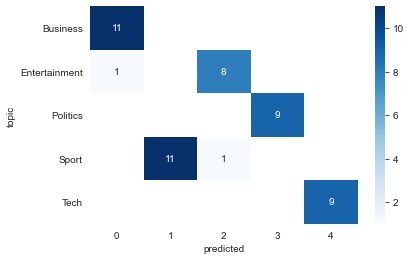

In [20]:
predictions = test_docs.topic.to_frame('topic').assign(predicted=topic_probabilities.idxmax(axis=1).values)
heatmap_data = predictions.groupby('topic').predicted.value_counts().unstack()
sns.heatmap(heatmap_data, annot=True, cmap='Blues');